### Import and Setup

In [1]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from utils.evaluate import evaluate_model
from scipy.stats import mode
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# paths
pickle_dir = "./results/pickles"
summary_dir = "./results/summaries"
visuals_dir = "./results/visuals"
datasets = ["rarefied", "clr"]

### Utility Functions

In [2]:
def load_feature_eng_output(dataset):
    path = os.path.join(pickle_dir, f"feature_eng_output_{dataset}.pkl")
    with open(path, "rb") as f:
        return pickle.load(f)

def get_best_config(data, dataset_name="unknown"):
    model_name = data["best_model_name"]
    best_auc = -1
    best_result = None
    best_model_id = None

    for section in ["feature_selection", "feature_extraction"]:
        for method, configs in data.get(section, {}).items():
            for n_feat, result in configs.items():
                auc = np.mean(result["AUC"])
                if auc > best_auc:
                    best_auc = auc
                    best_result = result
                    best_model_id = f"{dataset_name}_{model_name}_{method}_{n_feat}"

    print(f"Best config for {dataset_name.upper()} [{model_name}]: {best_model_id} → AUC: {best_auc:.4f}")
    return best_model_id, best_result["y_probs"], best_result["y_true"]

def soft_voting(probs_list):
    return np.mean(probs_list, axis=0)

def hard_voting_with_probs(probs_list):
    bin_preds = [(probs > 0.5).astype(int) for probs in probs_list]
    bin_preds = np.array(bin_preds)
    votes_for_1 = bin_preds.sum(axis=0)
    pseudo_probs = votes_for_1 / bin_preds.shape[0]
    majority_vote = (pseudo_probs >= 0.5).astype(int)
    return majority_vote, pseudo_probs

def stacking_probs(probs_list, y_true):
    X_meta = np.column_stack(probs_list)
    meta_model = LogisticRegression()
    meta_model.fit(X_meta, y_true)
    return meta_model.predict_proba(X_meta)[:, 1]

### Ensemble Aggregation & Evaluation

In [3]:
# === Setup ===
model_ids = []
y_probs_list = []
models_used_details = {}
y_true = None

for dataset in datasets:
    print(f"\nProcessing dataset: {dataset}")
    data = load_feature_eng_output(dataset)
    model_name = data["best_model_name"]
    model_id, probs, y_true = get_best_config(data, dataset)

    model_ids.append(model_id)
    y_probs_list.append(probs)

    # parsing method & num_features from model_id
    parts = model_id.split("_")
    method = parts[-1]
    num_features = int(parts[-2])

    models_used_details[model_id] = {
        "AUC": float(np.mean(data["feature_selection"].get(int(num_features), {}).get(method, {}).get("AUC", 0))),
        "method": method,
        "num_features": num_features,
        "y_probs": probs.tolist(),
        "y_true": y_true.tolist()
    }

    individual_model_probs = [probs.tolist() for probs in y_probs_list]

# === Running Ensemble Once ===
soft = soft_voting(y_probs_list)
hard, hard_probs = hard_voting_with_probs(y_probs_list)
stacked = stacking_probs(y_probs_list, y_true)

metrics_soft = evaluate_model(y_true, (soft > 0.5).astype(int), y_prob=soft)
metrics_hard = evaluate_model(y_true, hard, y_prob=hard_probs)
metrics_stacked = evaluate_model(y_true, (stacked > 0.5).astype(int), y_prob=stacked)

# === Saving Ensemble Output as Pickle ===
ensemble_output = {
    "datasets_used": datasets,
    "model_ids": model_ids,
    "y_true": y_true.tolist(),

    "soft_probs": soft.tolist(),
    "soft_preds": (soft > 0.5).astype(int).tolist(),

    "hard_probs": hard_probs.tolist(),
    "hard_preds": hard.tolist(),

    "stacking_probs": stacked.tolist(),
    "stacking_preds": (stacked > 0.5).astype(int).tolist(),

    "metrics_soft": metrics_soft,
    "metrics_hard": metrics_hard,
    "metrics_stacked": metrics_stacked,

    "models_used": models_used_details,
    "ensembler_model": "LogisticRegression",
    "voting_threshold": 0.5,
    "individual_model_probs": individual_model_probs,
}

os.makedirs(pickle_dir, exist_ok=True)
pickle_path = os.path.join(pickle_dir, "ensemble_output_combined.pkl")
with open(pickle_path, "wb") as f:
    pickle.dump(ensemble_output, f)

# === Saving JSON Simplified Summary ===
summary_json = {
    "note": "This is a simplified summary. For full details, use ensemble_output_combined.pkl",
    "datasets_used": datasets,
    "model_ids": model_ids,
    "selected_model_AUCs": {
        model_ids[0]: models_used_details[model_ids[0]]["AUC"],
        model_ids[1]: models_used_details[model_ids[1]]["AUC"]
    },
    "metrics_soft": metrics_soft,
    "metrics_hard": metrics_hard,
    "metrics_stacked": metrics_stacked,
    "ensembler_model": "LogisticRegression",
    "voting_threshold": 0.5
}

os.makedirs(summary_dir, exist_ok=True)
json_path = os.path.join(summary_dir, "ensemble_output_summary.json")
with open(json_path, "w") as f:
    import json
    json.dump(summary_json, f, indent=2)

# === Saving CSV Summary ===
summary_df = pd.DataFrame([
    {"Method": "Soft Voting", **metrics_soft},
    {"Method": "Hard Voting", **metrics_hard},
    {"Method": "Stacking", **metrics_stacked}
])
csv_path = os.path.join(summary_dir, "ensemble_metrics_combined.csv")
summary_df.to_csv(csv_path, index=False)

# === Print Summary ===
print("\nEnsemble Evaluation Results")
print("-" * 30)

print("Models used:")
for mid in model_ids:
    print(f"  {mid}")

print("\nSoft Voting:")
for k, v in metrics_soft.items():
    print(f"  {k:<10}: {v:.4f}" if v is not None else f"  {k:<10}: None")

print("\nHard Voting:")
for k, v in metrics_hard.items():
    print(f"  {k:<10}: {v:.4f}" if v is not None else f"  {k:<10}: None")

print("\nStacking:")
for k, v in metrics_stacked.items():
    print(f"  {k:<10}: {v:.4f}" if v is not None else f"  {k:<10}: None")

print("\nSaved outputs:")
print(f"  - Full ensemble output: {pickle_path}")
print(f"  - Summary JSON        : {json_path}")
print(f"  - Summary CSV         : {csv_path}")



Processing dataset: rarefied
Best config for RAREFIED [Light Gradient Boosting Model]: rarefied_Light Gradient Boosting Model_190_ANOVA F-value → AUC: 0.7828

Processing dataset: clr
Best config for CLR [Logistic Regression - Elastic Net]: clr_Logistic Regression - Elastic Net_40_Chi-Squared → AUC: 0.7865

Ensemble Evaluation Results
------------------------------
Models used:
  rarefied_Light Gradient Boosting Model_190_ANOVA F-value
  clr_Logistic Regression - Elastic Net_40_Chi-Squared

Soft Voting:
  AUC       : 0.6375
  Accuracy  : 0.5459
  Precision : 0.5455
  Recall    : 0.5459
  F1        : 0.5447

Hard Voting:
  AUC       : 0.6506
  Accuracy  : 0.6053
  Precision : 0.6271
  Recall    : 0.6053
  F1        : 0.5915

Stacking:
  AUC       : 0.7839
  Accuracy  : 0.7092
  Precision : 0.7106
  Recall    : 0.7092
  F1        : 0.7083

Saved outputs:
  - Full ensemble output: ./results/pickles/ensemble_output_combined.pkl
  - Summary JSON        : ./results/summaries/ensemble_output_

### ROC Curves

In [4]:
def generate_ensemble_roc_curve(y_true, probs_dict, tag, show_plot=True):
    roc_data = {}
    
    plt.figure()
    for label, probs in probs_dict.items():
        fpr, tpr, _ = roc_curve(y_true, probs)
        roc_auc_val = auc(fpr, tpr)
        roc_data[label] = {
            "fpr": fpr.tolist(),
            "tpr": tpr.tolist(),
            "auc": float(roc_auc_val)
        }
        plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_val:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – Ensemble ({tag})")
    plt.legend(loc="lower right")
    plt.grid(True)

    out_path = os.path.join(visuals_dir, "ensemble", f"{tag}_roc_curve.png")
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.savefig(out_path)

    if show_plot:
        plt.show()

    plt.close()
    print(f"Saved ROC curve to {out_path}")
    return roc_data


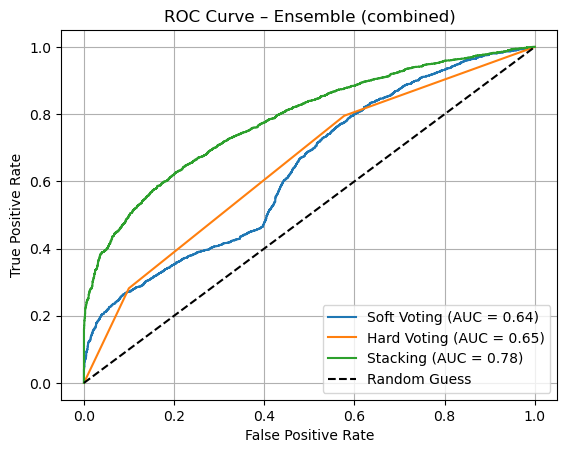

Saved ROC curve to ./results/visuals/ensemble/combined_roc_curve.png
Updated ensemble summary with ROC AUCs at: ./results/summaries/ensemble_output_summary.json
Saved combined ensemble output to: ./results/pickles/ensemble_output_combined.pkl


In [5]:
# === Plotting & Saving ROC Curve ===
roc_data = generate_ensemble_roc_curve(
    y_true,
    {
        "Soft Voting": soft,
        "Hard Voting": hard_probs,
        "Stacking": stacked
    },
    tag="combined",
    show_plot=True
)

ensemble_output["roc_data"] = roc_data

# === Updating JSON ===
json_path = os.path.join(summary_dir, "ensemble_output_summary.json")

with open(json_path, "r") as f:
    summary_json = json.load(f)

summary_json["roc_auc"] = {k: v["auc"] for k, v in roc_data.items()}

with open(json_path, "w") as f:
    json.dump(summary_json, f, indent=2)

print(f"Updated ensemble summary with ROC AUCs at: {json_path}")

# === Saving Output to Pickle ===
pickle_path = os.path.join(pickle_dir, "ensemble_output_combined.pkl")
with open(pickle_path, "wb") as f:
    pickle.dump(ensemble_output, f)
print(f"Saved combined ensemble output to: {pickle_path}")
